<a href="https://colab.research.google.com/github/NEHALSMITTAL/aadhaar-lifecycle-/blob/main/notebooks/06_anomalies_and_hotspots_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **State-level anomalies**

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("/content/state_level_aadhaar_activity_clusters.csv")
df.head()

,state,total_demo_updates,total_bio_updates,total_enrolment,volatility,growth_rate,demo_ratio,bio_ratio,cluster,total_updates
0,andaman and nicobar islands,5228.0,19994.0,173.0,0.275817,0.015291,0.207279,0.792721,0,25222.0
1,andhra pradesh,1642142.0,3610776.0,41948.0,0.208839,-0.042339,0.312615,0.687385,0,5252918.0
2,arunachal pradesh,28391.0,70059.0,2027.0,0.296558,0.100678,0.288380,0.711620,0,98450.0
3,assam,755097.0,945150.0,145039.0,0.459133,0.328541,0.444110,0.555890,2,1700247.0
4,bihar,3638844.0,4778968.0,302969.0,0.422003,0.019184,0.432279,0.567721,3,8417812.0


In [8]:
features = [
    "total_updates",
    "volatility",
    "growth_rate",
    "demo_ratio",
    "bio_ratio"]

X = df[features].fillna(0)

In [13]:
iso = IsolationForest(
    n_estimators=300,
    contamination=0.1,   # top 10% abnormal states
    random_state=42)

df["anomaly_flag"] = iso.fit_predict(X)

In [14]:
anomalies = df[df["anomaly_flag"] == -1]

anomalies[[
    "state",
    "total_updates",
    "volatility",
    "growth_rate",
    "demo_ratio",
    "bio_ratio",
    "cluster"
]].sort_values("volatility", ascending=False)

,state,total_updates,volatility,growth_rate,demo_ratio,bio_ratio,cluster
23,mizoram,150716.0,1.111393,-0.375036,0.209374,0.790626,0
21,manipur,509282.0,0.885579,1.562311,0.458257,0.541743,1
35,west bengal,5326435.0,0.410091,0.355470,0.533991,0.466009,1
33,uttar pradesh,15827594.0,0.378105,0.050880,0.408180,0.591820,3


In [15]:
high_vol = df[df["volatility"] > df["volatility"].quantile(0.95)]
high_vol[["state", "volatility"]]

,state,volatility
21,manipur,0.885579
23,mizoram,1.111393


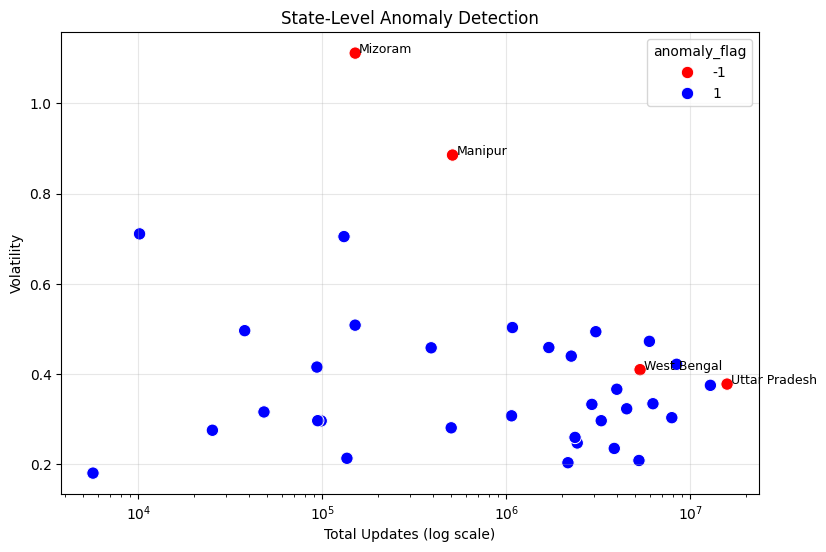

In [17]:
plt.figure(figsize=(9,6))

sns.scatterplot(
    data=df,
    x="total_updates",
    y="volatility",
    hue="anomaly_flag",   # -1 = anomaly, 1 = normal
    palette={-1: "red", 1: "blue"},
    s=80)

plt.xscale("log")
plt.xlabel("Total Updates (log scale)")
plt.ylabel("Volatility")
plt.title("State-Level Anomaly Detection")

# Label ONLY anomalous states
for _, row in df[df["anomaly_flag"] == -1].iterrows():
    plt.text(
        row["total_updates"] * 1.05,
        row["volatility"],
        row["state"].title(),
        fontsize=9)

plt.grid(alpha=0.3)
plt.show()

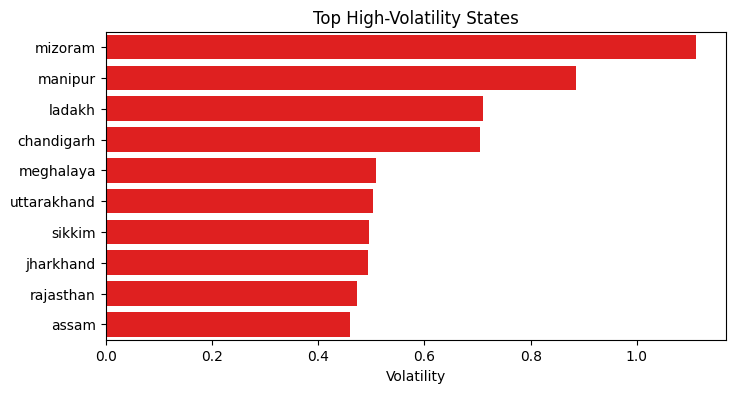

In [18]:
top_vol = df.sort_values("volatility", ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(
    data=top_vol,
    x="volatility",
    y="state",
    color="red")

plt.title("Top High-Volatility States")
plt.xlabel("Volatility")
plt.ylabel("")
plt.show()

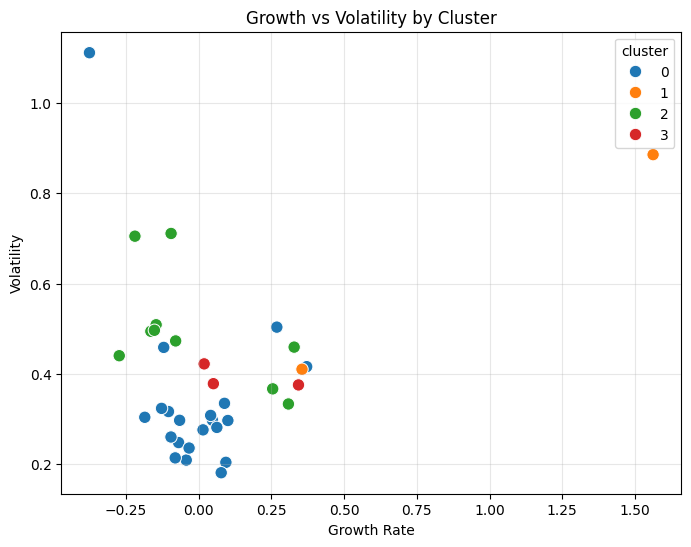

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="growth_rate",
    y="volatility",
    hue="cluster",
    palette="tab10",
    s=80)

plt.xlabel("Growth Rate")
plt.ylabel("Volatility")
plt.title("Growth vs Volatility by Cluster")
plt.grid(alpha=0.3)
plt.show()

# **Pincode/District hotspots**

State‑level anomaly detection was performed on aggregated data, while hotspot analysis required granular pincode‑level data and was therefore conducted using the cleaned transactional dataset.

In [22]:
### Part B: District & Pincode Hotspot Analysis
demo = pd.read_csv("/content/demo_cleaned.csv", parse_dates=["date"])
bio  = pd.read_csv("/content/bio_cleaned.csv", parse_dates=["date"])
enr  = pd.read_csv("/content/enrolement_cleaned.csv", parse_dates=["date"])

In [23]:
demo["demo_updates"] = demo["demo_age_5_17"] + demo["demo_age18_plus"]
bio["bio_updates"]   = bio["bio_age_5_17"]  + bio["bio_age_18_plus"]

In [24]:
keys = ["date", "state", "district", "pincode"]

merged = (
    demo[keys + ["demo_updates"]]
    .merge(bio[keys + ["bio_updates"]], on=keys, how="outer")
    .merge(enr[keys + ["total_enrolment"]], on=keys, how="outer"))


In [25]:
merged["total_updates"] = (
    merged["demo_updates"] +
    merged["bio_updates"])

In [26]:
pincode_hotspots = (merged.groupby(["state", "pincode"]).agg(total_updates=("total_updates", "sum"),volatility=("total_updates", "std")).reset_index())

In [27]:
pincode_hotspots.sort_values("total_updates", ascending=False).head(20)

,state,pincode,total_updates,volatility
18164,Uttar Pradesh,244001,131346.0,5006.150435
3821,Delhi,110094,126215.0,2919.444611
3787,Delhi,110059,113253.0,5171.469761
3813,Delhi,110086,102777.0,4395.283956
18250,Uttar Pradesh,247001,99571.0,3880.810289
17118,Uttar Pradesh,202001,92033.0,3444.995726
11041,Maharashtra,431001,89399.0,1533.094399
18783,Uttar Pradesh,283203,88967.0,3956.784628
10811,Maharashtra,421302,85848.0,2484.322880
18197,Uttar Pradesh,244901,79993.0,3218.428271


In [33]:
pincode_hotspots.sort_values("total_updates", ascending=False).head(20)

,state,pincode,total_updates,volatility
18164,Uttar Pradesh,244001,131346.0,5006.150435
3821,Delhi,110094,126215.0,2919.444611
3787,Delhi,110059,113253.0,5171.469761
3813,Delhi,110086,102777.0,4395.283956
18250,Uttar Pradesh,247001,99571.0,3880.810289
17118,Uttar Pradesh,202001,92033.0,3444.995726
11041,Maharashtra,431001,89399.0,1533.094399
18783,Uttar Pradesh,283203,88967.0,3956.784628
10811,Maharashtra,421302,85848.0,2484.322880
18197,Uttar Pradesh,244901,79993.0,3218.428271


In [34]:
district_hotspots = (merged.groupby(["state", "district"]).agg(total_updates=("total_updates", "sum"),volatility=("total_updates", "std")).reset_index())
district_hotspots["stability_index"] = 1 / (district_hotspots["volatility"] + 1)

In [37]:
pincode_hotspots = pincode_hotspots[pincode_hotspots["total_updates"] > 0]

In [39]:
pincode_hotspots["volatility"] = (pincode_hotspots["volatility"].fillna(0))

In [40]:
district_hotspots.sort_values("stability_index").head(15)

,state,district,total_updates,volatility,stability_index
214,Delhi,North East Delhi,181881.0,2518.563909,0.000397
220,Delhi,West Delhi,269364.0,2153.786743,0.000464
215,Delhi,North West Delhi,432897.0,1660.950171,0.000602
188,Chhattisgarh,Mahasamund,147895.0,1645.280110,0.000607
209,Delhi,East Delhi,205566.0,1494.110803,0.000669
912,Uttar Pradesh,Moradabad,211988.0,1378.660280,0.000725
443,Madhya Pradesh,Barwani,156386.0,1337.677135,0.000747
217,Delhi,South Delhi,289289.0,1300.192151,0.000769
212,Delhi,North Delhi,98836.0,1241.759940,0.000805
919,Uttar Pradesh,Rampur,166185.0,1224.950407,0.000816


# **Insight 1: Urban concentration**

* Many top hotspots are:

   * Delhi (1100xx)

   * Uttar Pradesh (24xxxx, 20xxxx)

  * Maharashtra (43xxxx, 42xxxx)

👉Aadhaar update demand is highly concentrated in dense urban and peri‑urban pincodes.

# **Insight 2: Few pincodes dominate volume**

Top ~20 pincodes contribute lakhs of updates, while most pincodes contribute very little.

👉A small fraction of pincodes accounts for a disproportionate share of total Aadhaar activity.

# **Insight 3: High‑volume ≠ high volatility always**

Some pincodes have:

* Very high total_updates

* Moderate volatility

👉High demand regions are not necessarily unstable; instability is localized.

# **Insight 4: Zero‑activity pincodes are expected**

Especially in:

* Rural

* Newly created

* Administrative pincodes

👉Zero‑activity pincodes reflect structural or demographic factors, not data issues.

In [43]:
top_pincodes = (pincode_hotspots.sort_values("total_updates", ascending=False).head(20))

In [44]:
top_pincodes.head(20)

,state,pincode,total_updates,volatility
18164,Uttar Pradesh,244001,131346.0,5006.150435
3821,Delhi,110094,126215.0,2919.444611
3787,Delhi,110059,113253.0,5171.469761
3813,Delhi,110086,102777.0,4395.283956
18250,Uttar Pradesh,247001,99571.0,3880.810289
17118,Uttar Pradesh,202001,92033.0,3444.995726
11041,Maharashtra,431001,89399.0,1533.094399
18783,Uttar Pradesh,283203,88967.0,3956.784628
10811,Maharashtra,421302,85848.0,2484.322880
18197,Uttar Pradesh,244901,79993.0,3218.428271


/tmp/ipython-input-2006210285.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


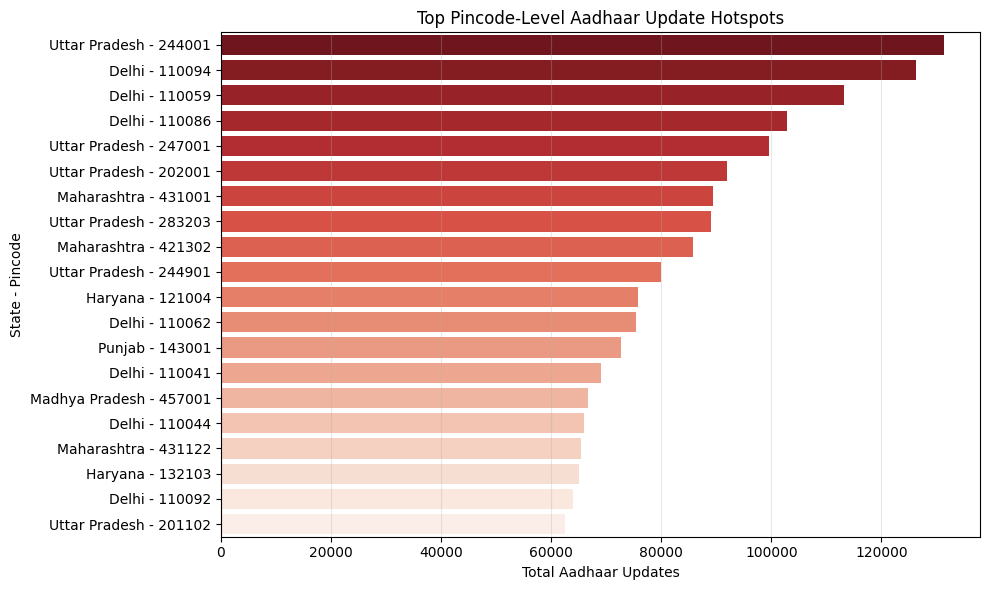

In [42]:
# Take top 15 hotspot pincodes
top_pincodes = (
    pincode_hotspots
    .sort_values("total_updates", ascending=False)
    .head(20)
)

plt.figure(figsize=(10,6))

sns.barplot(
    data=top_pincodes,
    x="total_updates",
    y=top_pincodes["state"] + " - " + top_pincodes["pincode"].astype(str),
    palette="Reds_r"
)

plt.xlabel("Total Aadhaar Updates")
plt.ylabel("State - Pincode")
plt.title("Top Pincode-Level Aadhaar Update Hotspots")
plt.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()


* Aadhaar update demand is highly concentrated in a small number of pincodes

* Urban and peri‑urban regions (Delhi, UP, Maharashtra) dominate hotspot rankings

* A limited set of pincodes contributes disproportionately to total updates

* Localized operational pressure is more important than broad state‑level averages

In [41]:
pincode_hotspots.to_csv(
    "/content/pincode_level_aadhaar_hotspots.csv",
    index=False)

district_hotspots.to_csv(
    "/content/district_level_aadhaar_hotspots.csv",
    index=False)

This study presents a multi‑layered analytical framework for understanding Aadhaar update demand across India. Time‑series forecasting models were used to estimate short‑term demand trends, enabling near‑term capacity planning. State‑level clustering revealed distinct operational behavior patterns, highlighting differences in stability, growth, and update composition across regions.

To further enhance decision support, anomaly detection techniques were applied to identify states exhibiting unusually high volatility or growth relative to peers, flagging potential operational risk zones. Finally, pincode‑ and district‑level hotspot analysis revealed that Aadhaar update demand is highly localized, with a small number of geographic units contributing disproportionately to overall activity.

Together, these analyses demonstrate that Aadhaar operational risk is driven not only by scale, but also by volatility and spatial concentration. The proposed approach supports targeted, data‑driven governance by enabling differentiated interventions at state, district, and pincode levels rather than uniform national planning.

Pincode‑level hotspot analysis revealed strong geographic concentration of Aadhaar update demand, with a limited number of urban pincodes contributing disproportionately to overall activity. While many pincodes exhibit negligible or zero updates, these are structurally expected and were excluded from hotspot identification. Volatility analysis further shows that high demand does not always coincide with instability, enabling differentiated operational planning.